In [ ]:
!pip install -q pytorch-tabnet
!pip install --upgrade "s3fs>=2023.6.0"

In [50]:
import pandas as pd

# Set the width to a large value
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)  # Ensure all columns are shown

## Tabnet Balanced weights Evaluation

### 1. Loading Train, Val and Test Data

In [1]:
import pandas as pd
from tqdm import tqdm

# Paths to the data on S3
base_path = "s3://fireguarddata/data/preprocessed_data/"
paths = {
    "train": f"{base_path}train.csv",
    "val": f"{base_path}val.csv",
    "test": f"{base_path}test.csv"
}

# Function to load data in chunks
def load_data_in_chunks(path, chunksize=1_000_000):
    chunks = []
    for chunk in tqdm(pd.read_csv(path, chunksize=chunksize, storage_options={"anon": False}), desc=f"Loading {path}"):
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# Load Train, Validation, and Test sets
print("Loading Train Data...")
train_df = load_data_in_chunks(paths["train"])
print(f"Train Data Loaded: {train_df.shape}")

print("Loading Validation Data...")
val_df = load_data_in_chunks(paths["val"])
print(f"Validation Data Loaded: {val_df.shape}")

print("Loading Test Data...")
test_df = load_data_in_chunks(paths["test"])
print(f"Test Data Loaded: {test_df.shape}")

print("All data loaded and ready for evaluation.")


Loading Train Data...


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/fsspec/registry.py:283: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)
Loading s3://fireguarddata/data/preprocessed_data/train.csv: 65it [10:42,  9.89s/it]


Train Data Loaded: (64434342, 30)
Loading Validation Data...


Loading s3://fireguarddata/data/preprocessed_data/val.csv: 9it [01:21,  9.05s/it]


Validation Data Loaded: (8054293, 30)
Loading Test Data...


Loading s3://fireguarddata/data/preprocessed_data/test.csv: 9it [01:28,  9.87s/it]


Test Data Loaded: (8054293, 30)
All data loaded and ready for evaluation.


In [31]:
train_df.columns

Index(['latitude', 'longitude', 'u10', 'v10', 'sp', 'lai_hv', 'lai_lv', 'tvl',
       'cl', 'swvl1', 'daynight', 'tvh', 'ie', 'd2m', 't2m', 'tcc', 'tcrw',
       'rsn', 'sd', 'tsn', 'slt', 'year', 'month', 'day', 'skt', 'wind_speed',
       'wind_direction', 'fuel_load', 'fuel_availability', 'fire_occurrence'],
      dtype='object')

In [38]:
train_df.head()

,latitude,longitude,u10,v10,sp,lai_hv,lai_lv,tvl,cl,swvl1,...,slt,year,month,day,skt,wind_speed,wind_direction,fuel_load,fuel_availability,fire_occurrence
0,-1.854739,1.186848,1.913886,-0.261135,1.118435,1.541443,0.105153,0.358779,3.198913,0.405177,...,-0.852486,-1.154279,-1.209036,-0.471339,0.347115,1.280399,0.019511,1.322502,1.123581,0
1,-0.079326,-0.376767,0.267480,0.095035,1.531714,-0.566924,1.064474,0.169215,-0.195362,1.218112,...,-0.852486,-1.154279,-1.832142,1.471559,-0.706624,-0.821879,0.217420,0.018410,-0.357045,0
2,0.387888,-0.083589,2.215039,0.314499,-1.622600,0.160309,1.840784,1.306600,0.250367,0.500081,...,1.304566,0.444995,0.348730,1.471559,0.876439,1.681323,0.167036,0.974894,0.758136,1
3,-1.574411,1.284574,-0.226584,0.341623,-0.220243,0.835162,1.069541,1.306600,-0.340481,-0.755683,...,-0.852486,1.404559,0.037177,1.471559,-0.000930,-1.077623,0.910134,1.179899,1.630340,1
4,-0.826868,0.405040,0.671729,-0.800230,0.970570,1.143510,-0.692320,0.358779,-0.390988,-0.833477,...,1.304566,-0.834424,-0.274376,0.900119,0.496858,0.025605,-0.325659,0.628582,1.060474,0


In [9]:
X_train = train_df.drop(columns=["fire_occurrence"]).values
y_train = train_df["fire_occurrence"].values

X_val = val_df.drop(columns=["fire_occurrence"]).values
y_val = val_df["fire_occurrence"].values

X_test = test_df.drop(columns=["fire_occurrence"]).values
y_test = test_df["fire_occurrence"].values

print("Shapes of split datasets:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

Shapes of split datasets:
X_train: (64434342, 29), y_train: (64434342,)
X_val:   (8054293, 29), y_val:   (8054293,)
X_test:  (8054293, 29), y_test:  (8054293,)


### Loading the Trained Model

In [5]:
import s3fs
import tarfile
import joblib
# S3 Path to your model artifact
model_s3_path = "s3://fireguarddata/models/tabnet/pytorch-training-2025-03-30-06-45-49-350/output/model.tar.gz"
local_path = "model.tar.gz"

# Download the model from S3
fs = s3fs.S3FileSystem(anon=False)
fs.get(model_s3_path, local_path)

# Extract the tar.gz file
with tarfile.open(local_path, "r:gz") as tar:
    tar.extractall(path="./")
print("Model extracted!")



# Load the extracted model
tabnet_balanced_model = joblib.load("tabnet_model.pkl")
print("Model loaded successfully!")

Model extracted!
Model loaded successfully!


### Step 1: Making Predictions
We’ll use the predict method for class predictions and predict_proba for probability scores.
The function will take input data (features) and the trained model.
- Return:
    - Predicted labels.
    - Predicted probabilities (confidence scores).

In [7]:
def predict_with_tabnet(model, X):
    """
    Generate predictions and probabilities using a trained TabNet model.

    Parameters:
        model: The loaded TabNet model.
        X: Features (numpy array).

    Returns:
        y_pred: Predicted labels.
        y_proba: Predicted probabilities for class 1 (fire occurrence).
    """
    # Predict class labels (0 or 1)
    y_pred = model.predict(X)
    
    # Predict probabilities (probability of class 1, fire)
    y_proba = model.predict_proba(X)[:, 1]  # Extract the probability for class 1

    print(f"Predictions: {y_pred[:5]}")
    print(f"Probabilities: {y_proba[:5]}")
    return y_pred, y_proba


**Run the predictions for train and validation data**

In [10]:
# Training predictions
y_train_pred, y_train_proba = predict_with_tabnet(tabnet_balanced_model, X_train)

# Validation predictions
y_val_pred, y_val_proba = predict_with_tabnet(tabnet_balanced_model, X_val)

print("Predictions for training and validation data complete!")


Predictions: [0 0 1 1 0]
Probabilities: [4.8138631e-13 6.0360388e-16 9.2821884e-01 8.1653470e-01 1.7699404e-11]
Predictions: [0 1 0 1 0]
Probabilities: [4.7395301e-09 8.9019364e-01 1.9309062e-01 7.6447564e-01 1.0895779e-08]
Predictions for training and validation data complete!


### Evaluating the Model
Let's evaluate the model using:

- Confusion Matrix: To understand the distribution of true positives, true negatives, false positives, and false negatives.

Classification Report: To get precision, recall, F1-score, and accuracy.

ROC Curve and AUC: To visualize the trade-off between sensitivity and specificity.

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred, y_proba, data_type="Validation"):
    """
    Evaluate the model using confusion matrix, classification report, and ROC curve.

    Parameters:
        y_true: Ground truth labels.
        y_pred: Predicted labels.
        y_proba: Predicted probabilities for class 1 (fire).
        data_type: String to indicate the type of data (train/validation/test).
    """
    print(f"\n=== {data_type} Data Evaluation ===")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot with Seaborn
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt=',', cmap="Reds", cbar=True, annot_kws={"size": 14, "weight": "bold"}, 
                xticklabels=["No Fire", "Fire"], yticklabels=["No Fire", "Fire"])

    plt.title(f"{data_type} Data - Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{data_type} Data - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


#### **Evaluate training predictions**


=== Training Data Evaluation ===
Confusion Matrix:
[[48886398  8083989]
 [  355211  7108744]]


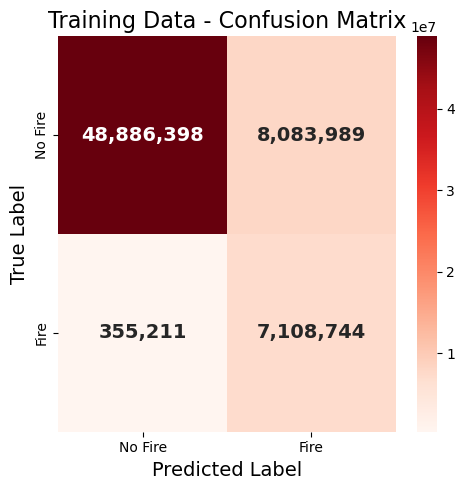


Classification Report:
              precision    recall  f1-score   support

           0     0.9928    0.8581    0.9205  56970387
           1     0.4679    0.9524    0.6275   7463955

    accuracy                         0.8690  64434342
   macro avg     0.7303    0.9053    0.7740  64434342
weighted avg     0.9320    0.8690    0.8866  64434342

AUC: 0.9408


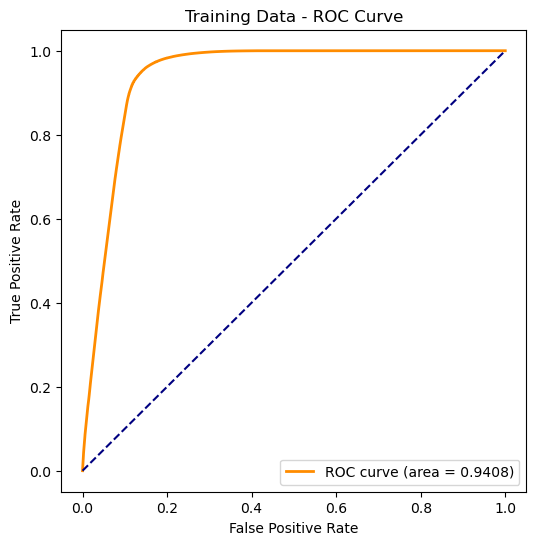

In [28]:
# Evaluate training predictions
evaluate_model(y_train, y_train_pred, y_train_proba, data_type="Training")

#### **Evaluate validation predictions**


=== Validation Data Evaluation ===
Confusion Matrix:
[[6111051 1010247]
 [  44186  888809]]


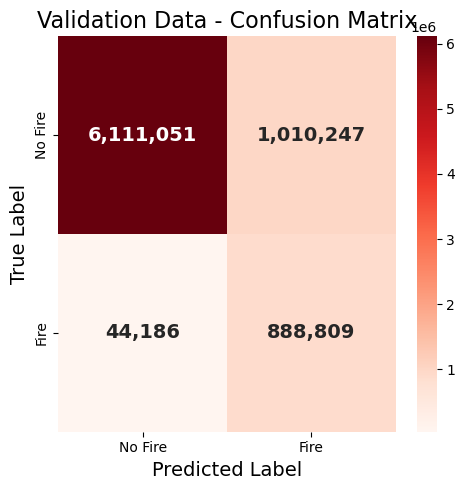


Classification Report:
              precision    recall  f1-score   support

           0     0.9928    0.8581    0.9206   7121298
           1     0.4680    0.9526    0.6277    932995

    accuracy                         0.8691   8054293
   macro avg     0.7304    0.9054    0.7741   8054293
weighted avg     0.9320    0.8691    0.8867   8054293

AUC: 0.9409


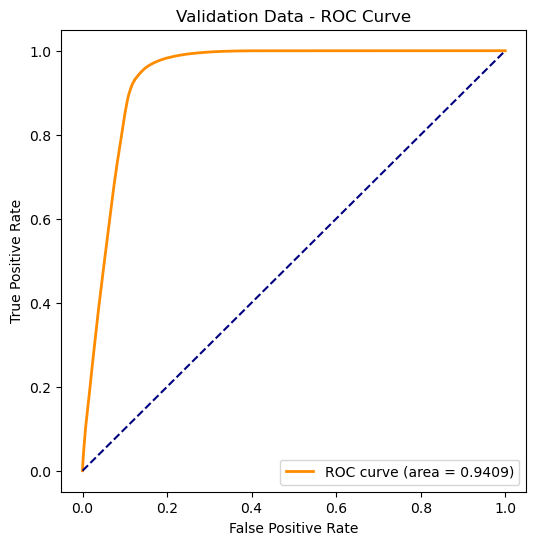

In [29]:
# Evaluate validation predictions
evaluate_model(y_val, y_val_pred, y_val_proba, data_type="Validation")

### **Inspecting Validation Test predictions**
Since the features were scaled during preprocessing, we'll need to inverse transform the scaled values to get the original values (especially important for coordinates like latitude and longitude).
Steps:
1. Load the Scaler: We need to load the StandardScaler used during training.
2. Inverse Transform: Use the scaler to convert the scaled values back to their original scale.
3. Select Features: Display some key features like: Latitude, Longitude, Wind Speed, Fuel Load, Wind Direction
4. Display Predictions: Show:
    - Actual label (fire_occurrence)
    - Predicted label (fire_predicted)
    - Predicted probability (fire_probability)
    - Selected features (after inverse scaling)

#### Getting inspections in proper form after rescaling
#### Step 1: Load a Sample of Unscaled Data from S3

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import boto3

# Connect to S3
s3 = boto3.client('s3')

# Load the unscaled data from S3 (use a sample if necessary)
bucket_name = 'fireguarddata'
file_key = 'data/preprocessed_data/df_full_preprocessed.csv'

# Read a sample of the unscaled data to avoid memory issues
response = s3.get_object(Bucket=bucket_name, Key=file_key)
df_full = pd.read_csv(response['Body'], nrows=100000)  # Load the first 100,000 rows as a representative sample

# Ensure the column order and feature columns match the original training data
feature_columns = ["latitude", "longitude", "wind_speed", "fuel_load", "fuel_availability", "wind_direction"]

df_full.head()

#### Step 2: Recreate the Scaler Using the Sample of Unscaled Data

In [42]:
def recreate_scaler_from_unscaled_data(df, feature_columns):
    # Fit the scaler on the original unscaled data
    scaler = StandardScaler()
    scaler.fit(df[feature_columns])
    return scaler

# Recreate the scaler using the sample from the unscaled dataset
scaler = recreate_scaler_from_unscaled_data(df_full, feature_columns)


#### Step 3: Inspect Predictions with Original Values

In [54]:
def generate_full_predictions(df, y_true, y_pred, y_proba, scaler, feature_columns):
    # Inverse transform the entire feature set
    original_features = scaler.inverse_transform(df[feature_columns])
    original_df = pd.DataFrame(original_features, columns=feature_columns)

    # Add the true and predicted values
    original_df["fire_occurrence"] = y_true
    original_df["fire_predicted"] = y_pred
    
    # Format the probability to 5 decimal places
    formatted_proba = np.round(y_proba, 5)
    original_df["fire_probability"] = formatted_proba

    print("Generated predictions DataFrame.")
    return original_df

def save_predictions_to_s3(df, output_path):
    # Save the full predictions to CSV
    df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")


In [55]:
# Generate the full predictions DataFrame (no saving yet)
predictions_df = generate_full_predictions(val_df, y_val, y_val_pred, y_val_proba, scaler, feature_columns)

Generated predictions DataFrame.


In [59]:
# Inspect the first 10 rows
predictions_df.head(10)

,latitude,longitude,wind_speed,fuel_load,fuel_availability,wind_direction,fire_occurrence,fire_predicted,fire_probability
0,34.802694,-117.338151,1.971441,0.203084,0.434186,-110.725277,0,0,0.00000
1,41.177285,-122.513161,0.640302,5.539606,4.246453,186.127710,0,1,0.89019
2,37.744813,-120.295299,1.037103,3.747294,3.710174,-41.841773,0,0,0.19309
3,38.725519,-121.773873,0.881042,4.081430,3.520808,15.297202,1,1,0.76448
4,37.744813,-121.773873,2.833960,4.092381,3.999666,43.312161,0,0,0.00000
5,34.067164,-116.845293,2.635126,4.118063,4.486194,71.949339,0,0,0.00000
6,33.086458,-116.598863,2.934514,7.011080,6.061067,-149.719266,0,0,0.00000
7,33.331634,-114.873860,4.968004,0.203084,0.492238,-50.971383,0,0,0.00760
8,35.047871,-119.309583,1.475142,4.899495,4.862033,58.969292,0,0,0.00001
9,39.215873,-120.541728,1.790577,3.567124,2.775085,139.610843,1,1,0.86619


In [58]:
# Once you're satisfied, save the DataFrame to S3
save_predictions_to_s3(predictions_df, "s3://fireguarddata/outputs/tabnet1_val_predictions.csv")

Predictions saved to predictions.csv


### Plot Feature Importance

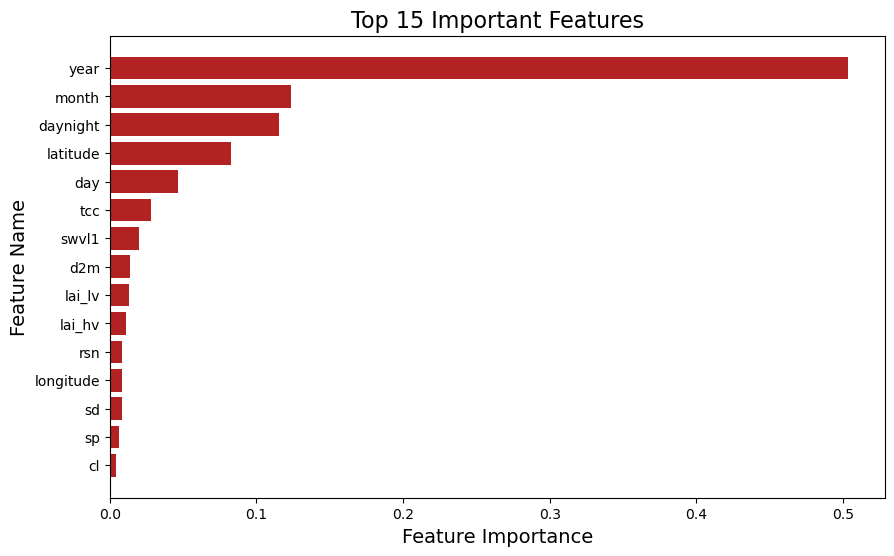

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance(tabnet_model, feature_names, top_n=15):
    """
    Plot the top N most important features from the trained TabNet model.

    Parameters:
        tabnet_model: The trained TabNet model.
        feature_names (list): List of feature names.
        top_n (int): Number of top features to display.
    """
    # Extract feature importance from the model
    feature_importances = tabnet_model.feature_importances_

    # Create a DataFrame for easy manipulation
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort by importance and take the top N
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='firebrick')
    plt.xlabel('Feature Importance', fontsize=14)
    plt.ylabel('Feature Name', fontsize=14)
    plt.title(f'Top {top_n} Important Features', fontsize=16)
    plt.gca().invert_yaxis()  # Invert to show the highest importance on top
    plt.show()

# Assuming the feature names are the same as in train_df
feature_names = train_df.drop(columns=["fire_occurrence"]).columns.tolist()

# Plot top 15 features
plot_feature_importance(tabnet_balanced_model, feature_names, top_n=15)


### Prediction Distribution
- Calculate the count and percentage for each combination of fire_occurrence (actual) and fire_predicted (predicted).
- Create a DataFrame to summarize the results.
- Plot the results for better visualization.


Prediction Distribution:
   Actual  Predicted    Count  Percentage
0       0          0  6111051   75.873214
1       0          1  1010247   12.542963
2       1          1   888809   11.035221
3       1          0    44186    0.548602


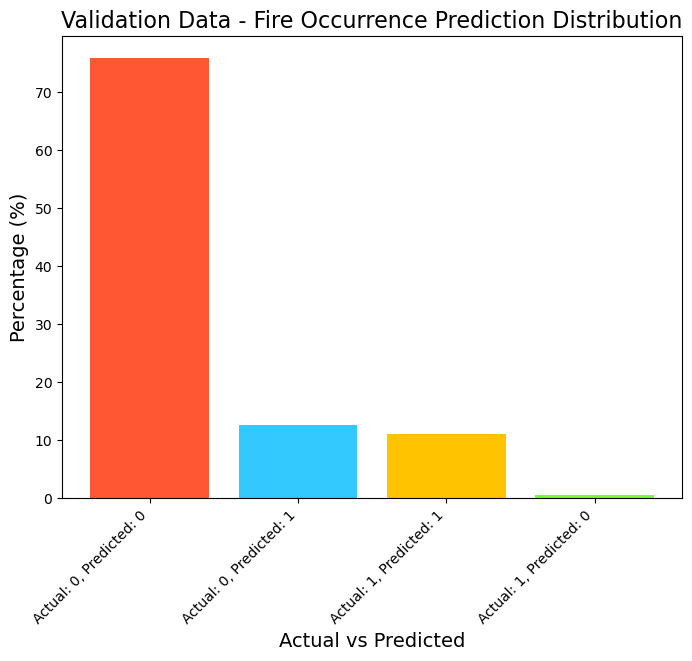

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_prediction_distribution(y_true, y_pred, data_type="Validation"):
    """
    Plot the distribution of actual vs predicted classes.

    Parameters:
        y_true (array): Ground truth labels.
        y_pred (array): Predicted labels.
        data_type (str): The type of dataset (train/val/test).
    """
    # Combine actual and predicted labels into a DataFrame
    df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

    # Calculate the counts and percentages
    counts = df.value_counts().reset_index(name='Count')
    counts['Percentage'] = (counts['Count'] / len(df)) * 100

    print("\nPrediction Distribution:")
    print(counts)

    # Plotting the distribution
    plt.figure(figsize=(8, 6))
    plt.bar(
        counts.apply(lambda row: f"Actual: {int(row['Actual'])}, Predicted: {int(row['Predicted'])}", axis=1),
        counts['Percentage'],
        color=['#ff5733', '#33c9ff', '#ffc300', '#75ff33']
    )
    plt.xlabel('Actual vs Predicted', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.title(f'{data_type} Data - Fire Occurrence Prediction Distribution', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plot distribution for validation data
plot_prediction_distribution(y_val, y_val_pred, data_type="Validation")


#### Inspecting misclassfications
Printed Sample of Misclassifications: Rows where the model predicted incorrectly

In [78]:
def inspect_misclassifications(df, y_true, y_pred, y_proba, scaler, feature_columns, dataset_name="val", sample_size=15):
    # Step 1: Create a copy of the dataframe and add predictions and probabilities
    misclassified_df = df.copy()
    misclassified_df['fire_occurrence'] = y_true
    misclassified_df['fire_predicted'] = y_pred
    misclassified_df['fire_probability'] = np.round(y_proba, 5)

    # Step 2: Filter rows where prediction is incorrect
    misclassified = misclassified_df[misclassified_df['fire_occurrence'] != misclassified_df['fire_predicted']]

    # Step 3: Inverse transform the features of the misclassified rows
    original_features = scaler.inverse_transform(misclassified[feature_columns])
    original_df = pd.DataFrame(original_features, columns=feature_columns)

    # Step 4: Add the true and predicted values back
    original_df['fire_occurrence'] = misclassified['fire_occurrence'].values
    original_df['fire_predicted'] = misclassified['fire_predicted'].values
    original_df['fire_probability'] = misclassified['fire_probability'].values

    # Step 5: Display a sample of misclassifications
    print(f"\nSample Misclassifications from {dataset_name} set:")
    print(original_df.head(sample_size))

    return original_df


In [79]:
# Example usage for validation data
val_misclassified_df = inspect_misclassifications(
    val_df, y_val, y_val_pred, y_val_proba, scaler, feature_columns, dataset_name="validation", sample_size=15
)


Sample Misclassifications from validation set:
     latitude   longitude  wind_speed  fuel_load  fuel_availability  wind_direction  fire_occurrence  fire_predicted  fire_probability
0   41.177285 -122.513161    0.640302   5.539606           4.246453      186.127710                0               1           0.89019
1   36.764107 -120.295299    1.615596   3.908039           3.468452       11.403155                0               1           0.57741
2   36.764107 -121.034586    2.243417   3.617186           3.535485        0.557552                0               1           0.93632
3   39.706226 -121.034586    3.855577   4.506041           3.881554     -106.553332                0               1           0.89263
4   40.441756 -121.034586    1.831397   5.193216           3.091115     -167.614732                0               1           0.65126
5   39.706226 -120.295299    1.167587   5.190087           4.511386       43.847769                0               1           0.89697
6   38.

#### Visualizing Misclassifications in Val
- Histogram of Misclassified Predictions: Shows the distribution of predicted probabilities for fire.
- Spatial Distribution Plot: Highlights where the model made errors in predicting fires.

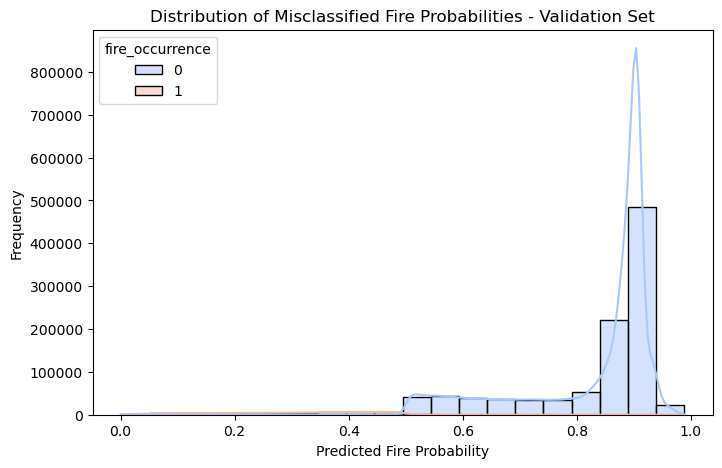

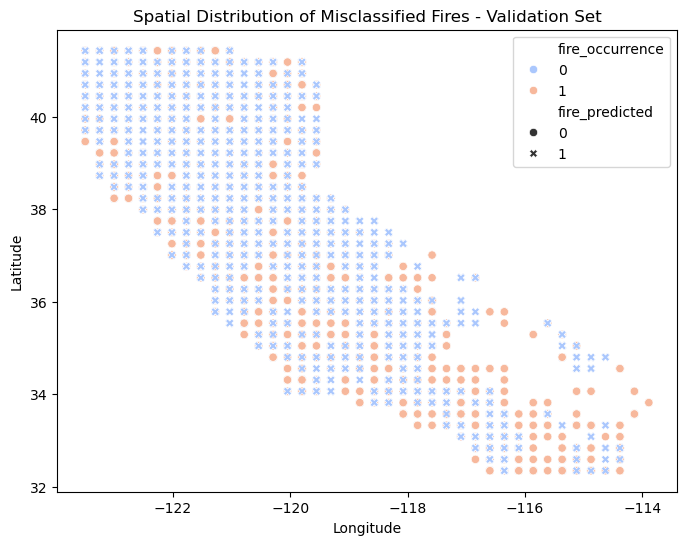

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_misclassifications(misclassified_df, dataset_name="val"):
    # Plot 1: Distribution of Misclassified Fire Probabilities
    plt.figure(figsize=(8, 5))
    sns.histplot(data=misclassified_df, x="fire_probability", hue="fire_occurrence", kde=True, bins=20, palette="coolwarm")
    plt.title(f"Distribution of Misclassified Fire Probabilities - {dataset_name.capitalize()} Set")
    plt.xlabel("Predicted Fire Probability")
    plt.ylabel("Frequency")
    plt.show()

    # Plot 2: Spatial Distribution of Misclassifications
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=misclassified_df, x="longitude", y="latitude", hue="fire_occurrence", style="fire_predicted", palette="coolwarm")
    plt.title(f"Spatial Distribution of Misclassified Fires - {dataset_name.capitalize()} Set")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Example usage for validation misclassifications
visualize_misclassifications(val_misclassified_df, dataset_name="validation")


**Observations:**
Distribution of Misclassified Fire Probabilities:
- The histogram shows that most of the misclassifications occur when the predicted fire probability is high (close to 1).
- This indicates that the model is sometimes overconfident in predicting fires that did not actually happen.

Spatial Distribution of Misclassified Fires:
- The scatter plot shows where the misclassifications occurred geographically.
- The blue crosses (0) represent areas predicted as no fire, while orange crosses (1) represent areas predicted as fire.
- Misclassified points (dots and stars) are spread across the region, suggesting that there might be no clear geographical pattern to the errors.

### Feature Distribution
- Feature Distribution Comparison: Visualize the distribution of key features (like wind speed and fuel load) separately for correctly classified and misclassified instances.
- Model Confidence Comparison: Compare the predicted fire probability (model confidence) between correctly classified and misclassified points.
- Flexible Visualization: Allow the function to work with both validation and test sets.

In [83]:
def analyze_misclassification_patterns(df, y_true, y_pred, y_proba, scaler, feature_columns, dataset_name="val"):
    # Step 1: Create a copy of the dataframe and add predictions and probabilities
    analysis_df = df.copy()
    analysis_df['fire_occurrence'] = y_true
    analysis_df['fire_predicted'] = y_pred
    analysis_df['fire_probability'] = np.round(y_proba, 5)

    # Step 2: Identify misclassified and correctly classified instances
    misclassified = analysis_df[analysis_df['fire_occurrence'] != analysis_df['fire_predicted']]
    correctly_classified = analysis_df[analysis_df['fire_occurrence'] == analysis_df['fire_predicted']]

    # Step 3: Inverse transform features
    misclassified_features = scaler.inverse_transform(misclassified[feature_columns])
    correctly_features = scaler.inverse_transform(correctly_classified[feature_columns])

    misclassified_df = pd.DataFrame(misclassified_features, columns=feature_columns)
    correctly_df = pd.DataFrame(correctly_features, columns=feature_columns)

    # Adding labels to the dataframes
    misclassified_df['type'] = 'Misclassified'
    correctly_df['type'] = 'Correctly Classified'
    misclassified_df['fire_probability'] = misclassified['fire_probability'].values
    correctly_df['fire_probability'] = correctly_classified['fire_probability'].values

    # Combine for comparison
    combined_df = pd.concat([misclassified_df, correctly_df])

    # Plot 1: Feature Distribution Comparison
    plt.figure(figsize=(12, 6))
    sns.histplot(data=combined_df, x="wind_speed", hue="type", kde=True, bins=30, palette="coolwarm", element="step")
    plt.title(f"Wind Speed Distribution for Misclassified vs. Correctly Classified - {dataset_name.capitalize()} Set")
    plt.xlabel("Wind Speed")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.histplot(data=combined_df, x="fuel_load", hue="type", kde=True, bins=30, palette="coolwarm", element="step")
    plt.title(f"Fuel Load Distribution for Misclassified vs. Correctly Classified - {dataset_name.capitalize()} Set")
    plt.xlabel("Fuel Load")
    plt.show()

    # Plot 2: Model Confidence Comparison
    plt.figure(figsize=(12, 6))
    sns.histplot(data=combined_df, x="fire_probability", hue="type", kde=True, bins=30, palette="coolwarm", element="step")
    plt.title(f"Model Confidence for Misclassified vs. Correctly Classified - {dataset_name.capitalize()} Set")
    plt.xlabel("Predicted Fire Probability")
    plt.show()


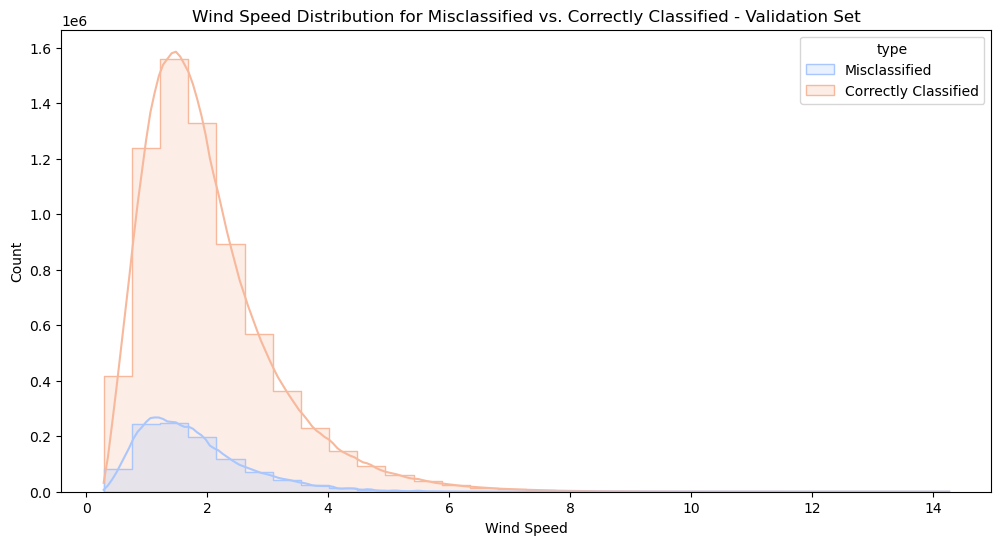

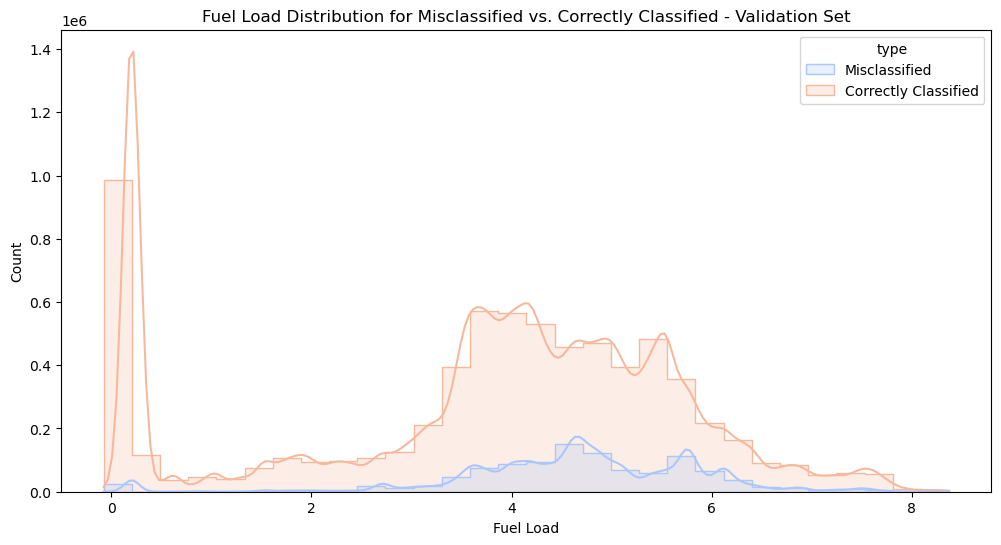

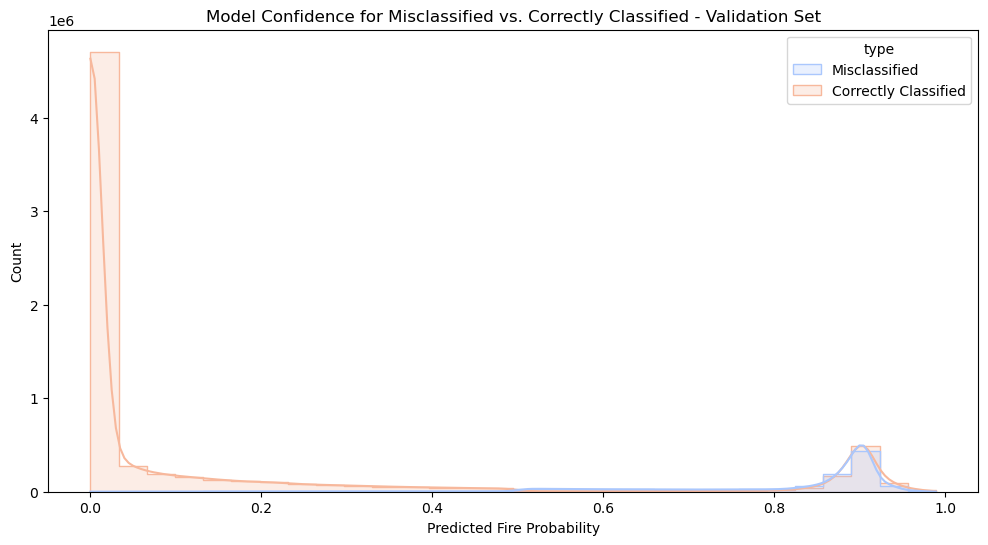

In [84]:
# Example usage for validation data
analyze_misclassification_patterns(val_df, y_val, y_val_pred, y_val_proba, scaler, feature_columns, dataset_name="validation")

## Test Evaluation
1. Step 1: Make Predictions on the Test Data: Since we already have the trained model loaded and the test data prepared, let's make predictions.
2. Step 2: Identify Misclassifications: We will find instances where the predicted label differs from the actual label.
3. Step 3: Inspect Sample Misclassifications: We will print a few rows of misclassified data, including relevant features.
4. Step 4: Visualize Misclassification Patterns: We will plot a few important features to see where the model struggles.

In [63]:
# Step 1: Make predictions on the test data
y_test_pred = tabnet_balanced_model.predict(X_test)
y_test_proba = tabnet_balanced_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (fire)

print("Test predictions completed!")

Test predictions completed!


**Evaluate on test data set**


=== Test Data Evaluation ===
Confusion Matrix:
[[6112019 1009280]
 [  44322  888672]]


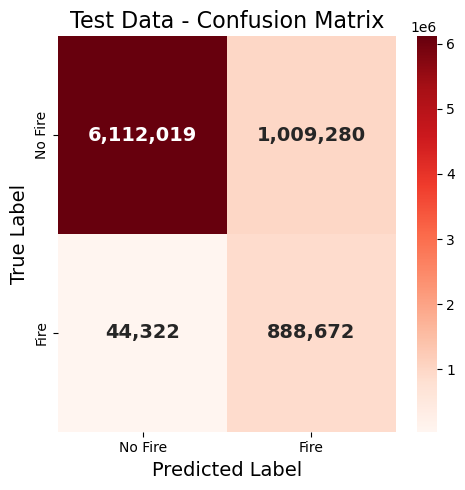


Classification Report:
              precision    recall  f1-score   support

           0     0.9928    0.8583    0.9206   7121299
           1     0.4682    0.9525    0.6278    932994

    accuracy                         0.8692   8054293
   macro avg     0.7305    0.9054    0.7742   8054293
weighted avg     0.9320    0.8692    0.8867   8054293

AUC: 0.9409


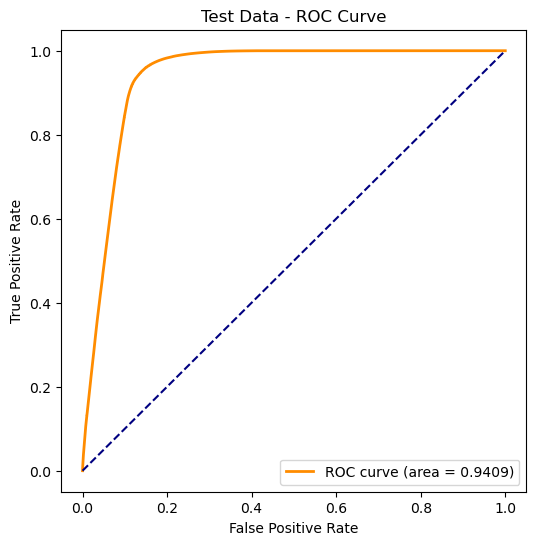

In [66]:
# Evaluate test predictions
evaluate_model(y_test, y_test_pred, y_test_proba, data_type="Test")

#### Test predictions

In [67]:
# Generate the full predictions DataFrame (no saving yet)
test_predictions_df = generate_full_predictions(test_df, y_test, y_test_pred, y_test_proba, scaler, feature_columns)

Generated predictions DataFrame.


In [68]:
# Inspect the first 10 rows
test_predictions_df.head(10)

,latitude,longitude,wind_speed,fuel_load,fuel_availability,wind_direction,fire_occurrence,fire_predicted,fire_probability
0,37.989990,-120.048870,2.229124,2.905763,2.673954,14.536373,0,0,0.15996
1,40.441756,-120.048870,1.393162,5.394636,5.462972,-13.484414,0,0,0.00000
2,35.047871,-119.063154,1.045849,4.702899,4.390882,-61.340493,0,0,0.26114
3,35.538224,-118.323867,0.989235,4.367850,4.147414,187.907934,0,0,0.00004
4,38.235166,-121.034586,1.949310,4.327175,4.147151,76.692499,0,0,0.00000
5,36.764107,-121.281015,1.405365,4.354031,4.034313,-19.350754,1,1,0.91047
6,35.538224,-118.323867,0.825211,4.112197,3.140653,-164.414357,0,0,0.00000
7,36.518930,-116.845293,0.744956,0.200738,0.476089,185.149385,0,0,0.00055
8,40.932109,-123.252448,0.824772,4.678911,4.016805,191.098119,0,1,0.90816
9,37.254460,-117.831009,1.421333,5.526048,5.806990,38.948590,0,0,0.00000


**saving test predictions**

In [69]:
# Once you're satisfied, save the DataFrame to S3
save_predictions_to_s3(test_predictions_df, "s3://fireguarddata/outputs/tabnet1_test_predictions.csv")

Predictions saved to s3://fireguarddata/outputs/tabnet1_test_predictions.csv


**inspecting test misclassified predictions**

In [81]:
# Example usage for test data
test_misclassified_df = inspect_misclassifications(
    test_df, y_test, y_test_pred, y_test_proba, scaler, feature_columns, dataset_name="test", sample_size=15
)


Sample Misclassifications from test set:
     latitude   longitude  wind_speed  fuel_load  fuel_availability  wind_direction  fire_occurrence  fire_predicted  fire_probability
0   40.932109 -123.252448    0.824772   4.678911           4.016805      191.098119                0               1           0.90816
1   37.989990 -121.527444    2.607728   3.646258           3.873258       69.373077                0               1           0.83551
2   39.706226 -123.006019    1.974530   3.519800           2.991517     -135.474183                0               1           0.67547
3   40.441756 -122.513161    2.557574   5.734638           4.566124      -90.146194                0               1           0.89943
4   40.686932 -123.006019    0.481981   4.123539           3.390682     -157.915937                0               1           0.90816
5   39.215873 -122.266732    0.608062   5.409759           4.604366      -47.601646                0               1           0.90767
6   40.932109

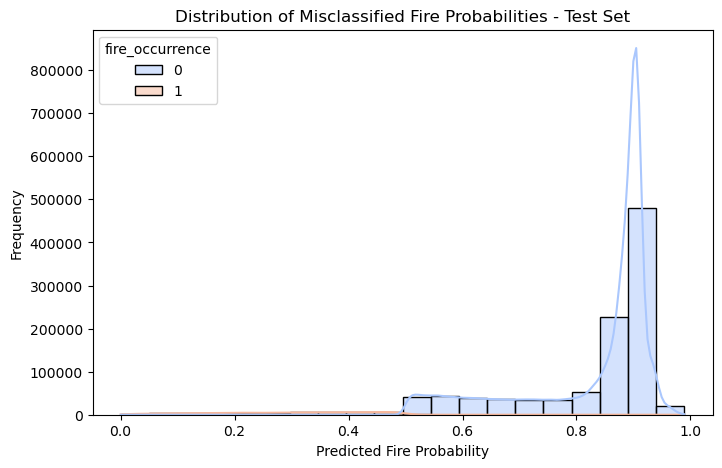

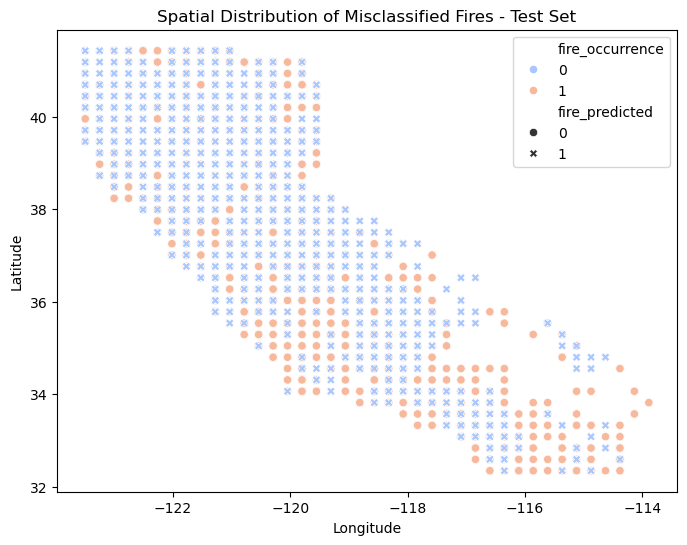

In [82]:
# Example usage for test misclassifications
visualize_misclassifications(test_misclassified_df, dataset_name="test")

**visualizaing distribution of key features for correctly classified and misclassified instances**

In [ ]:
# Example usage for test data
analyze_misclassification_patterns(test_df, y_test, y_test_pred, y_test_proba, scaler, feature_columns, dataset_name="test")
